# Characterizing segment length distribution and estimating alpha

### Import packages

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import math

### From a dataframe with all fractures

In [2]:
# Read data
path = 'data/dataframe/Tsan_structural_all.csv'
#path = 'data/dataframe/slick.csv'
df = pd.read_csv(path)

### Power law and alpha estimation (α)
To fit the length distribution to a power law, various scales of measurements are required, we use the proposition from Bonnet et al. (2001). The authors explain that the value of the exponent depends on type of distribution and bin type. The table below shows the relationship between commonly used distributions to determine power law length distributions and their exponents.

| Distribution | log bin | lin bin |
|--------------|---------|---------|
| Frequency    | α - 1   | α       |
| Density      | α       | α       |
| Cumulative   | α - 1   | α - 1

In: Bonnet, E., Bour, O., Odling, N.E., Davy, P., Main, I., Cowie, P., Berkowitz, B., 2001. Scaling of fracture systems in geological media. Reviews of Geophysics 39, 347–383.   |   |

### From frequencies using linear bins

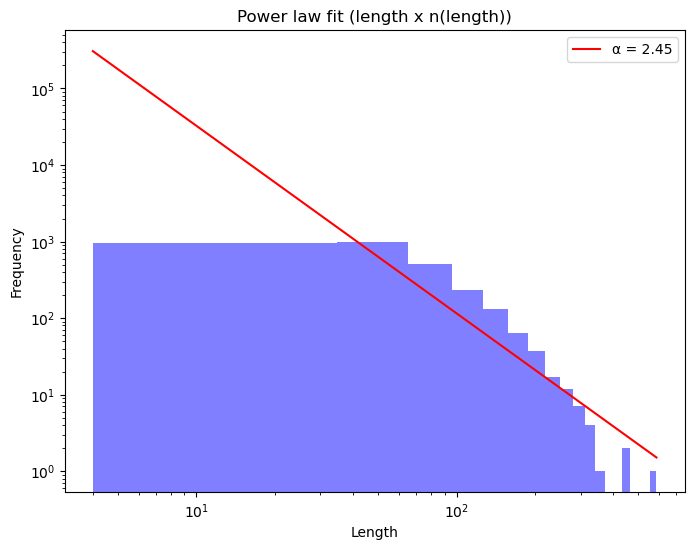

In [3]:
# Fit a power law and estimate alpha for all fractures using frequencies and linear bins
length = df['length'].dropna()[df['length'].dropna() > 0] 
bin_edge = np.linspace(length.min(), length.max(), 20)
hist, bins = np.histogram(length, bins=bin_edge)
bin_centers = 0.5 * (bin_edge[1:] + bin_edge[:-1])

mask = hist > 0
log_x = np.log(bin_centers[mask])
log_y = np.log(hist[mask])

slope, intercept, *_ = st.linregress(log_x, log_y)
alpha = -slope

# Plot the data and the fitted power law
plt.figure(figsize=(8, 6))
plt.hist(length, bins=bin_edge, density=False, color='blue', alpha=0.5)
x_fit = np.logspace(np.log10(min(length)), np.log10(max(length)), 20)
y_fit = np.exp(intercept) * x_fit**slope
plt.plot(x_fit, y_fit, color='red', label=f'α = {alpha:.2f}')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Power law fit (length x n(length))')
plt.legend()
plt.show()

## From density using logaritmic bins

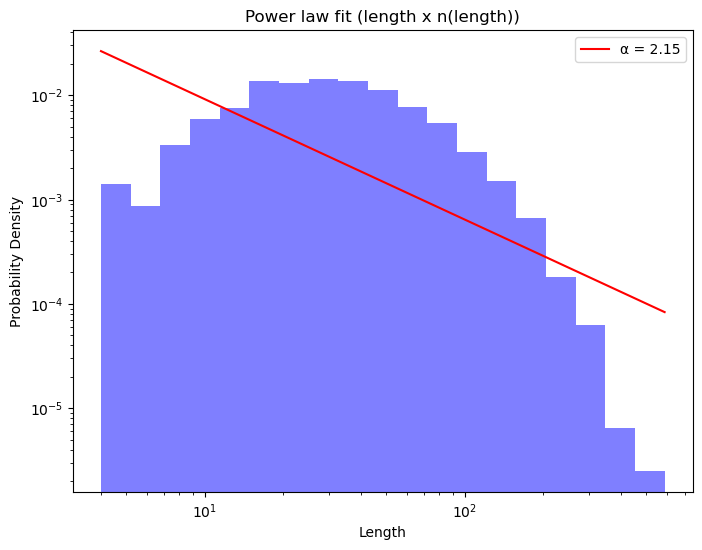

In [4]:
# Fit a power law and estimate alpha for all fractures using densities and logbins
bin_edge = np.logspace(np.log10(length.min()), np.log10(length.max()), 20)
hist, bins = np.histogram(length, bins=bin_edge, density=True)
bin_centers = 0.5 * (bin_edge[1:] + bin_edge[:-1])

mask = hist > 0
log_x = np.log(bin_centers[mask])
log_y = np.log(hist[mask])

slope, intercept, *_ = st.linregress(log_x, log_y)
c = -slope
alpha = c +1

# Plot the data and the fitted power law
plt.figure(figsize=(8, 6))
plt.hist(length, bins=bin_edge, density=True, color='blue', alpha=0.5)
x_fit = np.logspace(np.log10(min(length)), np.log10(max(length)), 20)
y_fit = np.exp(intercept) * x_fit**slope
plt.plot(x_fit, y_fit, color='red', label=f'α = {alpha:.2f}')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Length')
plt.ylabel('Probability Density')
plt.title('Power law fit (length x n(length))')
plt.legend()
plt.show()

### From cumulative distribution using logaritmic bins

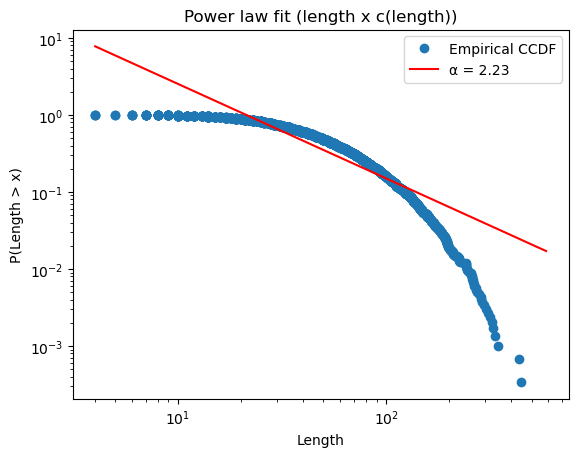

In [5]:
# Sort and compute ccdf in log-log
sorted_lengths = np.sort(length)
ccdf = 1 - np.arange(1, len(sorted_lengths)+1) / len(sorted_lengths)

#Fit power-law
mask = (ccdf > 0)
log_x = np.log(sorted_lengths[mask])
log_y = np.log(ccdf[mask])
slope, intercept, *_ = st.linregress(log_x, log_y)
c = -slope
alpha = c +1

# Plot
plt.plot(sorted_lengths, ccdf, marker='o', linestyle='none', label='Empirical CCDF')
x_fit = np.logspace(np.log10(sorted_lengths.min()), np.log10(sorted_lengths.max()), 20)
y_fit = np.exp(intercept) * x_fit**slope
plt.plot(x_fit, y_fit, color='red', label=f'α = {alpha:.2f}')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Length')
plt.ylabel('P(Length > x)')
plt.title('Power law fit (length x c(length))')
plt.legend()
plt.show()

### Fitting and estimation by set

In [6]:
# Calculate and store azimuth in radians
df['azimuth_rad'] = np.deg2rad(df['azimuth'])

In [12]:
#Define sets from azimuth (0-180)
def families(azimuth):
    if (0 <= azimuth < 40) or (140 <= azimuth <= 180):
        return 'NS'
    elif 40 <= azimuth < 70:
        return 'NESW'
    elif 70 <= azimuth < 100:
        return 'EW'
    elif 100 <= azimuth < 140:
        return 'NWSE'

df['set'] = df['azimuth'].apply(families)

## For families with frequencies and linear bins

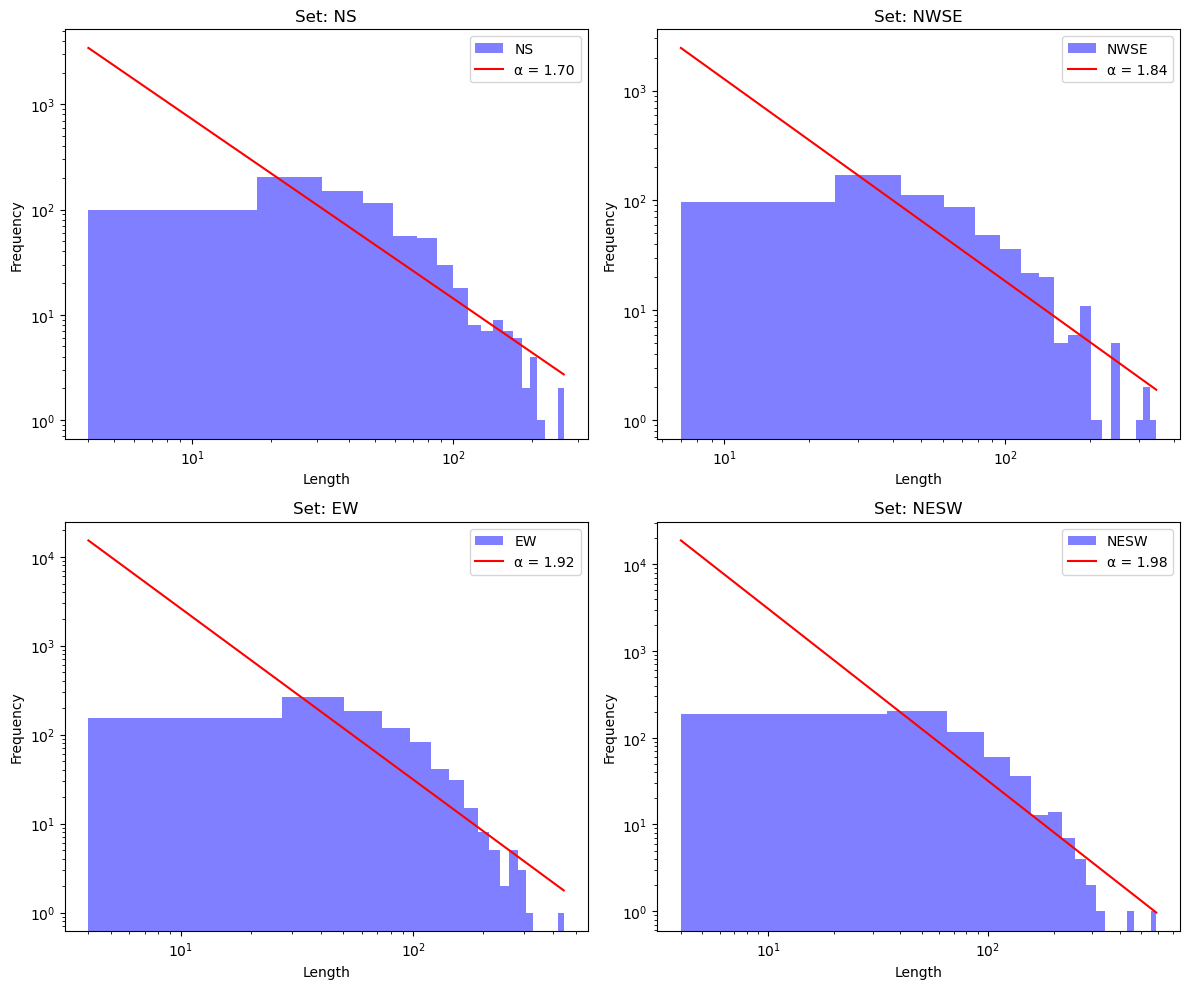

In [14]:
# Get unique fracture sets for dinamic subplot
sets = df['set'].dropna().unique()
n_sets = len(sets)

# Define subplot grid: try to keep it square-ish
ncols = 2
nrows = math.ceil(n_sets / ncols)

# Create the subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows))
axes = axes.flatten()  # Flatten for easy indexing

for i, family in enumerate(sets):
    ax = axes[i]
    filtered_df = df[df['set'] == family]
    length = filtered_df['length'].dropna()
    length = length[length > 0]

    bin_edge = np.linspace(length.min(), length.max(), 20)
    hist, bins = np.histogram(length, bins=bin_edge)
    bin_centers = 0.5 * (bin_edge[1:] + bin_edge[:-1])

    mask = hist > 0
    log_x = np.log(bin_centers[mask])
    log_y = np.log(hist[mask])

    slope, intercept, *_ = st.linregress(log_x, log_y)
    alpha = -slope

    # Plot
    ax.hist(length, bins=bin_edge, density=False, alpha=0.5, color='blue', label=family)
    x_fit = np.logspace(np.log10(length.min()), np.log10(length.max()), 100)
    y_fit = np.exp(intercept) * x_fit**slope
    ax.plot(x_fit, y_fit, color='red', label=f'α = {alpha:.2f}')

    # Format
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Length')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Set: {family}')
    ax.legend()

# Turn off any unused axes
for j in range(n_sets, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## For families with ccdf and logaritmic bins

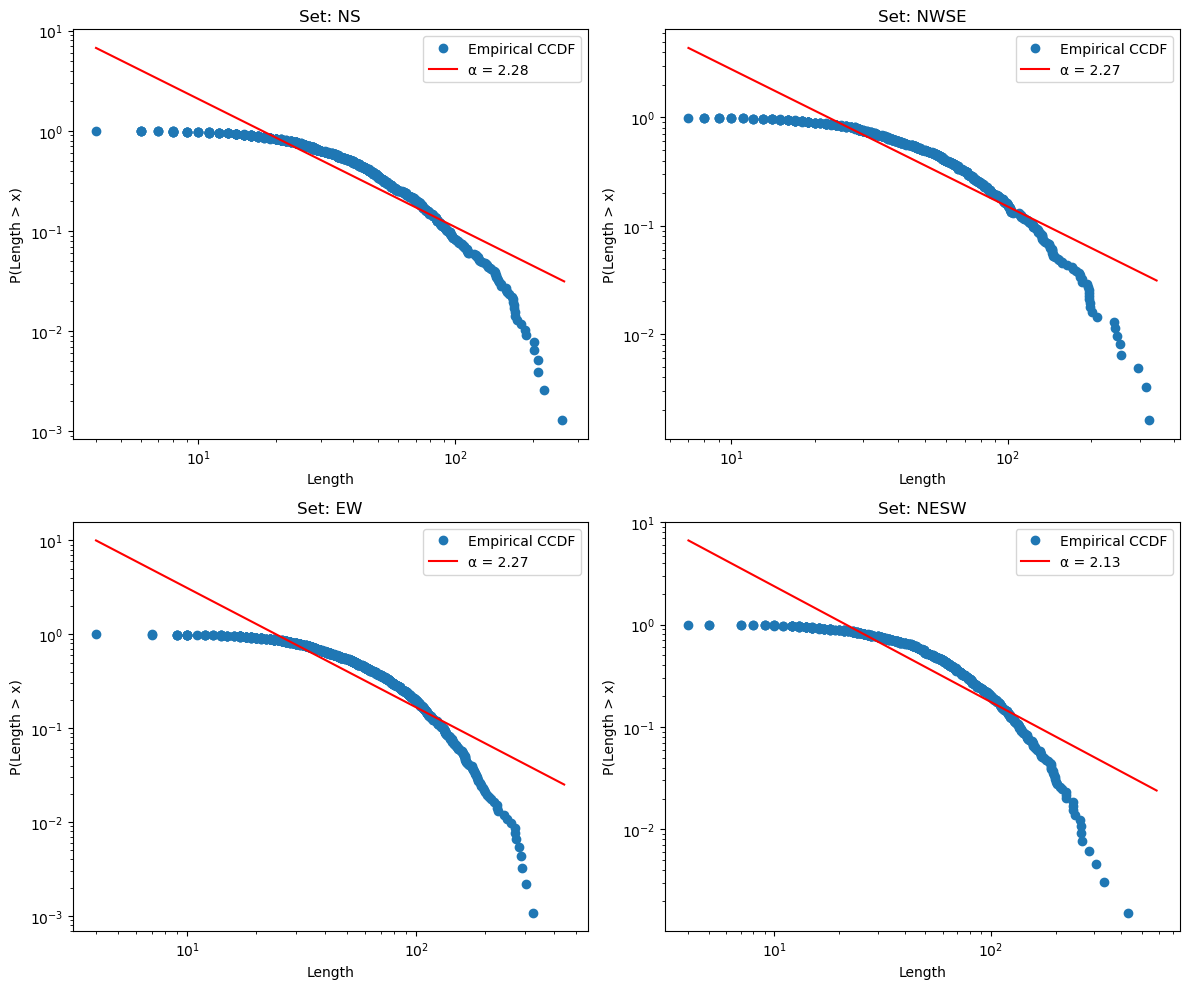

In [15]:
# Get unique fracture sets for dinamic subplot
sets = df['set'].dropna().unique()
n_sets = len(sets)

# Define subplot grid: try to keep it square-ish
ncols = 2
nrows = math.ceil(n_sets / ncols)

# Create the subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows))
axes = axes.flatten()  # Flatten for easy indexing

for i, family in enumerate(sets):
    ax = axes[i]
    filtered_df = df[df['set'] == family]
    length = filtered_df['length'].dropna()
    length = length[length > 0]

    # Sort and compute ccdf in log-log
    sorted_lengths = np.sort(length)
    ccdf = 1.0 - np.arange(1, len(sorted_lengths)+1) / len(sorted_lengths)

    #Fit power-law
    mask = ccdf > 0
    log_x = np.log(sorted_lengths[mask])
    log_ccdf = np.log(ccdf[mask])
    slope, intercept, *_ = st.linregress(log_x, log_ccdf)
    c = -slope
    alpha = c +1

    # Plot
    ax.plot(sorted_lengths, ccdf, marker='o', linestyle='none', label='Empirical CCDF')
    x_fit = np.logspace(np.log10(sorted_lengths.min()), np.log10(sorted_lengths.max()), 100)
    y_fit = np.exp(intercept) * x_fit**slope
    ax.plot(x_fit, y_fit, color='red', label=f'α = {alpha:.2f}')

    # Format
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Length')
    ax.set_ylabel('P(Length > x)')
    ax.set_title(f'Set: {family}')
    ax.legend()

# Turn off any unused axes
for j in range(n_sets, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()